In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
df = pd.read_csv("data/tweet_emotions.csv")
pd.set_option('display.max_colwidth', None)
df.head(10)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin on your call...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,"@dannycastillo We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends
6,1956968487,sadness,"I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


In [6]:
df.shape

(40000, 3)

## Data Preprocessing and Feature Engineering

In [7]:

df['content'] = df['content'].str.replace(f"[{string.punctuation}]", "", regex=True).str.lower()
df['content'] = df['content'].str.replace(r'\d+', '', regex=True)

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_content(text):
    
    filtered = []
    words = text.split()
    for word in words:
        if word.lower() not in stop_words:
            stemmed = stemmer.stem(word.lower())
            filtered.append(stemmed)
    return " ".join(filtered)

df['cleaned_content'] = df['content'].apply(clean_content)
valid_indices = df['cleaned_content'].astype(bool)
filtered_content = df.loc[valid_indices, 'cleaned_content']
y = df.loc[valid_indices, 'sentiment']


vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(filtered_content)
x.shape

(39984, 45280)

## Model Traning -1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42)
model =  LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [9]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.34375390771539327


In [10]:
report = classification_report(y_test, y_pred, zero_division=0)
report

'              precision    recall  f1-score   support\n\n       anger       0.00      0.00      0.00        36\n     boredom       0.00      0.00      0.00        43\n       empty       0.50      0.01      0.02       173\n  enthusiasm       0.00      0.00      0.00       136\n         fun       0.16      0.01      0.03       365\n   happiness       0.35      0.35      0.35      1027\n        hate       0.41      0.10      0.17       261\n        love       0.49      0.36      0.41       783\n     neutral       0.32      0.61      0.42      1700\n      relief       0.36      0.03      0.05       303\n     sadness       0.38      0.23      0.28      1050\n    surprise       0.23      0.02      0.04       416\n       worry       0.34      0.46      0.39      1704\n\n    accuracy                           0.34      7997\n   macro avg       0.27      0.17      0.17      7997\nweighted avg       0.34      0.34      0.30      7997\n'

From the Report above i realized the model achieved a low model score of 34% because of two main issues:

            1. Class Imbalance
            2. Large Number of Emotion Categories

Understanding this i came up with a solution to combine the emotions in the sentiment column into 3 broad categories

            Positive, Negative, and Ambigiuous. Which i began to implement below

## Class Aggregation and Mapping

In [11]:
emotion_map = {
    'neutral': 'ambiguous',
    'empty': 'ambiguous',
    'surprise': 'ambiguous',

    
    'worry': 'negative',
    'sadness': 'negative',
    'hate': 'negative',
    'anger': 'negative',
    'boredom': 'negative',

    'happiness': 'positive',
    'love': 'positive',
    'fun': 'positive',
    'relief': 'positive',
    'enthusiasm': 'positive'

}
df['emotional_state'] = df['sentiment'].map(emotion_map)
df.head()

,tweet_id,sentiment,content,cleaned_content,emotional_state
0,1956967341,empty,tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part,tiffanylu know listenin bad habit earlier start freakin part,ambiguous
1,1956967666,sadness,layin n bed with a headache ughhhhwaitin on your call,layin n bed headach ughhhhwaitin call,negative
2,1956967696,sadness,funeral ceremonygloomy friday,funer ceremonygloomi friday,negative
3,1956967789,enthusiasm,wants to hang out with friends soon,want hang friend soon,positive
4,1956968416,neutral,dannycastillo we want to trade with someone who has houston tickets but no one will,dannycastillo want trade someon houston ticket one,ambiguous


# Model Refinement/ Model Training - 2

In [12]:
y = df.loc[valid_indices, 'emotional_state']
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 42)
model =  LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5773415030636488


In [14]:
report = classification_report(y_test, y_pred)
report

'              precision    recall  f1-score   support\n\n   ambiguous       0.46      0.43      0.45      2289\n    negative       0.62      0.65      0.64      3094\n    positive       0.61      0.62      0.61      2614\n\n    accuracy                           0.58      7997\n   macro avg       0.57      0.57      0.57      7997\nweighted avg       0.57      0.58      0.58      7997\n'

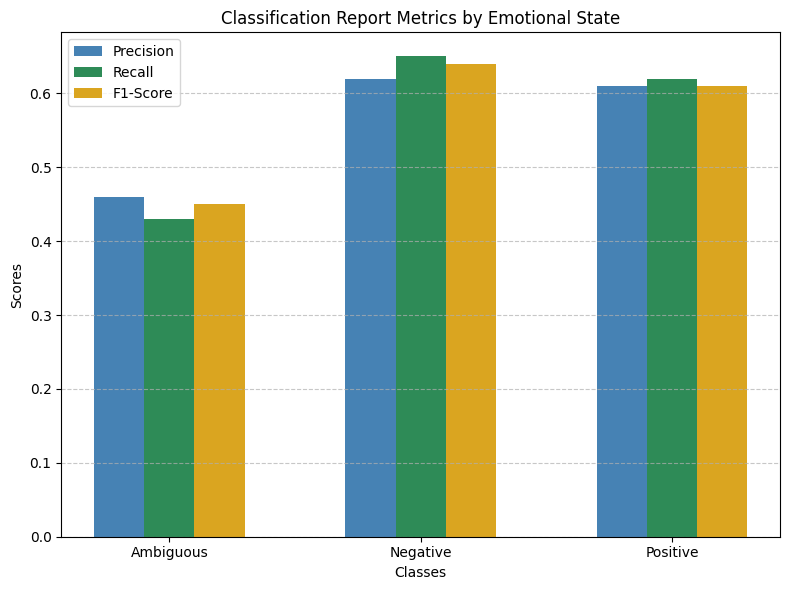

In [15]:


labels = ["Ambiguous", "Negative", "Positive"]
precision = [0.46, 0.62, 0.61]
recall = [0.43, 0.65, 0.62]
f1_score = [0.45, 0.64, 0.61]

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(8, 6))
plt.bar(x - width, precision, width, label="Precision", color="#4682B4")
plt.bar(x, recall, width, label="Recall", color="#2E8B57")
plt.bar(x + width, f1_score, width, label="F1-Score", color="#DAA520")

plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Classification Report Metrics by Emotional State")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Final Result and Conclusion

The model achieved a final accuracy of 57.7%, this is a significant improvement from the inital 34%. The bar chart above shows that the model performed best at detecting NEGATIVE EMOTIONS, followed by POSITIVE EMOTIONS. It also showed a weaker but much-improved performance on the AMBIGUOUS category, proving my solution was very much effective.